## CS536: Pruning Decision Trees
#### Done by - Vedant Choudhary, vc389
The purpose of this problem set is to look at the effect of pruning on decision trees. As before, we need a generative model for data so that we can run repeatable experiments. Let ${(X_1, Y_1),(X_2, Y_2), . . . ,(X_m, Y_m)}$ denote a data set, where $X_i$ represents a vector of k (binary) feature values, and $Y_i$ is a corresponding binary class or label that we will need to learn to be able to predict from the X-values.
We generate data via the following scheme, defining a distribution for our data set: Let $X = (X_0, X_1, X_2, X_3, . . . , X_{20})$
be a vector of binary values, satisfying the following
- $X_0 = 1$ with probability 1/2, $X_0 = 0$ with probability 1/2
- For i = 1, . . . , 14, $X_i = X_{i−1}$ with probability 3/4, and $X_i = 1 − X_{i−1}$ with probability 1/4.
- For i = 15, . . . , 20, $X_i = 1$ with probability 1/2, and $X_i = 0$ with probability 1/2.

The first feature value is uniformly random, and the next 14 features are strongly correlated, but the last 5 features are independent of everything else. There are 21 X-variables, so there are $2^{21} ≈ 2$ mil possible input X. Some of these are more likely than others. In general, we expect the training data to cover only a fraction of the total possible inputs, so consider data sets of size m where m ranges from 10 to 10,000. We then define Y to be

$$Y = majority(X_1, ....., X_7) if X_0 = 0$$
$$Y = majority(X_8, ....., X_{14}) if X_0 = 1$$

That is, if $X_0 = 0$, we take the majority value of $X_1$ through $X_7$ - otherwise we take the majority value of $X_8$ through
$X_{14}$. The values $X_{15}$ through $X_{20}$ are nothing but noise.

#### 1. Write a function to generate m samples of (X, Y), and another to fit a tree to that data using ID3. Write a third function to, given a decision tree f, estimate the error rate of that decision tree on the underlying data, err(f). Do this repeatedly for a range of m values, and plot the ‘typical’ error of a tree trained on m data points as a function of m. Does this agree with your intuition?

In [37]:
# Importing required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pprint
from tqdm import tqdm
from collections import Counter

%matplotlib inline

In [38]:
# Creating X (feature) vectors for the data
def create_data(k, m):
    X = [[0]*k for i in range(m)]
    for i in range(m):
        X[i][0] = int(np.random.choice(2, size=1))
        for j in range(1, k):
            if j <=14:
                temp = np.random.choice(2, 1, p=[0.25,0.75])
                if temp == 1:
                    X[i][j] = X[i][j-1]
                else:
                    X[i][j] = 1 - X[i][j-1]
            else:
                temp = np.random.choice(2, 1, p=[0.5,0.5])
                if temp == 1:
                    X[i][j] = 1
                else:
                    X[i][j] = 0
    return X 

# Return most common value
def majority(l):
    occurence = Counter(l)
    return occurence.most_common(1)[0][0]

# Creating target column for the data
def create_y(X, k, m):
    y = []
    for i in range(m):
        if X[i][0] == 0:
            y.append(majority(X[i][1:8]))
        elif X[i][0] == 1:
            y.append(majority(X[i][8:15]))
    return y

# Combining all the sub data points into a dataframe
def create_dataset(k, m):
    X = np.asarray(create_data(k, m))
    y = np.asarray(create_y(X, k, m)).reshape(m, 1)

    # Training data is an appended version of X and y arrays
    data = pd.DataFrame(np.append(X, y, axis=1), columns=["X" + str(i) for i in range(k)]+['Y'])
    return data

In [39]:
# Global variables, k - number of features, m - sample size, epsilon - a very small value (e-16) used to avoid divide by zero errors
k, m = 21, 100
epsilon = np.finfo(float).eps

train_data = create_dataset(k, m)
train_data.head()

,X0,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X12,X13,X14,X15,X16,X17,X18,X19,X20,Y
0,0,0,0,0,0,0,1,1,1,1,...,0,0,0,1,0,1,0,0,0,0
1,0,0,0,1,1,1,1,1,1,1,...,1,1,1,0,1,0,0,0,0,1
2,1,1,1,0,0,0,1,1,1,1,...,1,0,0,0,0,0,1,1,0,1
3,0,1,1,1,1,1,0,0,0,1,...,0,0,0,0,0,0,0,0,1,1
4,1,0,0,0,1,1,1,1,0,0,...,1,1,0,1,1,0,0,0,0,1


In [40]:
train_data.iloc[:,-1].value_counts()[0]

59

In [41]:
# Class for Decision Tree
class DecisionTree(): 
    '''
    Entropy function calculates the entropy of unique values in the target data i.e. entropy for 0 and 1
    Input - dataset
    Return - Entropy value for target
    '''
    def entropy(self, data):
#         Fetching the last column key (target column)
        target = data.keys()[-1]
        entropy_y = 0
#         Listing the unique values of target variable, here it is 0 and 1
        target_vals = data[target].unique()
        
        for val in target_vals:
            p = data[target].value_counts()[val]/len(data[target])
            entropy_y += -p*np.log2(p)
        return entropy_y
    
    '''
    Calculates the conditional entropy of the target variable w.r.t to the features i.e. H(Y|X)
    Input - dataset, feature
    Return - Conditional entropy    
    '''
    def conditional_entropy(self, data, feature):
#         Fetching the last column key (target column)
        target = data.keys()[-1]
#         Listing the unique values of target variable, here it is 0 and 1
        target_vals = data[target].unique()
#         Listing the unique values of current feature variable, here it is 0 and 1
        feature_vals = data[feature].unique()
        cond_entropy_y = 0
        
#         Going over the unique values of current feature, and calculation the cross-entropy
        for fval in feature_vals:
            entropy = 0
            for tval in target_vals:
#                 num calculates the number of data points that satisfy the feature and target values. Example - data points which have y as 0 and x as 0
                num = len(data[feature][data[feature] == fval][data[target] == tval])
#                 denom calculates the total number of data points satisfying feature = 0 or 1 (depends on fval)
                denom = len(data[feature][data[feature] == fval])
                e = num/(denom + epsilon)
                entropy += -(e)*np.log2(e + epsilon)
            cond_entropy_y += -(denom/len(data))*entropy
            
        return abs(cond_entropy_y)
    
    '''
    Calculates information gain value
    Input - dataset
    Return - max value of information gain feature
    '''
    def information_gain_split(self, data):
        IG = []
#         For every feature except the last column(y) in the dataset
        for key in data.keys()[:-1]:
            IG.append(self.entropy(data) - self.conditional_entropy(data, key))
            
        return data.keys()[:-1][np.argmax(IG)]
    
    '''
    Trims down the dataset as per the information gain node. Helps in building tree
    Input - dataset, node(which is the best split feature), val is either 0 or 1
    Return - trimmed dataset
    '''
    def get_subset(self, data, node, value):
        return data[data[node] == value].reset_index(drop=True)
    
    '''
    Get frequency of Y
    '''
    def get_freq(self, subset):
        target_val, target_counts = np.unique(subset[subset.keys()[-1]], return_counts=True)
        if len(target_counts) == 1:
            return target_val[0]
        else:
            if target_counts[1] > target_counts[0]:
                return target_val[1]
            else:
                return target_val[0]
    
    '''
    Builds the decision tree based on functions written above. It is a recursive function till leaf nodes found
    Input - dataset
    Return - the built decision tree, in a dictionary like format
    '''
    def build_tree(self, data, tree=None):
        target = data.keys()[-1]
        best_split = self.information_gain_split(data)
        feature_vals = data[best_split].unique()
        
        if tree is None:
            tree = {}
            tree[best_split] = {}
        
        for val in feature_vals:
            subset = self.get_subset(data, best_split, val)
            target_val, target_counts = np.unique(subset[subset.keys()[-1]], return_counts=True)
            if len(target_counts) == 1:
                tree[best_split][val] = target_val[0]
            else:
                tree[best_split][val] = self.build_tree(subset)        
        
        return tree
    
    def prune_by_sample_size(self, data, s, tree=None):
        target = data.keys()[-1]
        best_split = self.information_gain_split(data)
        feature_vals = data[best_split].unique()
        if tree is None:
            tree = {}
            tree[best_split] = {}
            
        for val in feature_vals:
            if len(data) <= s:
                tree[best_split][val] = self.get_freq(data)
            else:
                subset = self.get_subset(data, best_split, val)
                target_val, target_counts = np.unique(subset[subset.keys()[-1]], return_counts=True)
                if len(target_counts) == 1:
                    tree[best_split][val] = target_val[0]
                else:
                    tree[best_split][val] = self.prune_by_sample_size(subset, s)
        return tree
    
    '''
    Predicts the target value based on a data vector
    Input - a single row of dataset or a single X vector, decision tree
    Return - predicted value
    '''
    def predict(self, instance_data, tree):
        for node in tree.keys():
            value = instance_data[node]
            tree = tree[node][value]
            prediction = 0
            
            if type(tree) is dict:
                prediction = self.predict(instance_data, tree)
            else:
                prediction = tree
                break
        
        return prediction
    
    '''
    Predicts the target value and then calculates error based on the predictions
    Input - dataset, decision tree built
    Return - error
    '''
    def fit(self, data, tree):
        error = 0
        for i in range(len(data)):
            prediction = self.predict(data.iloc[i], tree)
            if prediction != data.iloc[i][-1]:
                error += 1
        return error/len(data)    
    
    '''
    Generates multiple datasets and finds error on those datasets
    Input - Built decision tree, feature values, sample size of dataset
    Return - typical error
    '''
    def generate_data_and_typical_error(self, tree, k, m):
        typical_error = 0
        for i in range(50):
            data = create_dataset(k, m)
            typical_error += self.fit(data, tree)

        typical_error = typical_error/50
        return typical_error

In [34]:
dt = DecisionTree()
tree = dt.build_tree(train_data)
pprint.pprint(tree)

Feature val:  1
[0 1] [1920 3090]
Feature val:  1
[0 1] [ 485 1985]
Feature val:  1
[0 1] [ 143 1357]
Feature val:  1
[0 1] [  53 1050]
Feature val:  1
[0 1] [ 14 918]
Feature val:  1
[0 1] [  5 827]
Feature val:  1
[1] [624]
Feature val:  0
[0 1] [  5 203]
Feature val:  1
[0 1] [  2 186]
Feature val:  0
[0 1] [ 2 15]
Feature val:  0
[1] [14]
Feature val:  1
[0 1] [2 1]
Feature val:  0
[0] [2]
Feature val:  1
[1] [1]
Feature val:  1
[1] [171]
Feature val:  0
[0 1] [ 3 17]
Feature val:  1
[0 1] [3 4]
Feature val:  0
[0] [3]
Feature val:  1
[1] [4]
Feature val:  0
[1] [13]
Feature val:  0
[0 1] [ 9 91]
Feature val:  1
[0 1] [ 2 74]
Feature val:  1
[1] [65]
Feature val:  0
[0 1] [2 9]
Feature val:  1
[1] [7]
Feature val:  0
[0 1] [2 2]
Feature val:  1
[0] [2]
Feature val:  0
[1] [2]
Feature val:  0
[0 1] [ 7 17]
Feature val:  0
[0 1] [7 7]
Feature val:  0
[0 1] [7 1]
Feature val:  0
[0] [7]
Feature val:  1
[1] [1]
Feature val:  1
[1] [6]
Feature val:  1
[1] [10]
Feature val:  0
[0 1] [ 39

Feature val:  0
[0] [62]
Feature val:  1
[0 1] [2 1]
Feature val:  0
[0] [2]
Feature val:  1
[1] [1]
Feature val:  1
[0 1] [1081  279]
Feature val:  1
[0 1] [320 238]
Feature val:  0
[0 1] [292  51]
Feature val:  0
[0 1] [250  13]
Feature val:  0
[0] [236]
Feature val:  1
[0 1] [14 13]
Feature val:  1
[0 1] [ 2 13]
Feature val:  1
[1] [13]
Feature val:  0
[0] [2]
Feature val:  0
[0] [12]
Feature val:  1
[0 1] [42 38]
Feature val:  0
[0 1] [35  3]
Feature val:  1
[1] [3]
Feature val:  0
[0] [35]
Feature val:  1
[0 1] [ 7 35]
Feature val:  1
[1] [33]
Feature val:  0
[0 1] [7 2]
Feature val:  0
[0] [7]
Feature val:  1
[1] [2]
Feature val:  1
[0 1] [ 28 187]
Feature val:  1
[0 1] [  9 156]
Feature val:  0
[0 1] [ 9 26]
Feature val:  1
[1] [18]
Feature val:  0
[0 1] [9 8]
Feature val:  1
[1] [8]
Feature val:  0
[0] [9]
Feature val:  1
[1] [130]
Feature val:  0
[0 1] [19 31]
Feature val:  0
[0 1] [15  7]
Feature val:  0
[0] [11]
Feature val:  1
[0 1] [4 7]
Feature val:  0
[0] [4]
Feature val

KeyboardInterrupt: 

In [ ]:
dt.prune_by_sample_size(train_data, 10)

In [10]:
error = dt.fit(train_data, tree)
error

0.0

In [12]:
# This function generates data depending on different values of m
def generate_data_varied_m(k):
    m = list(range(10, 100, 10))
    errors = []
    for i in tqdm(range(len(m))):
        train_data = create_dataset(k, m[i])
        dt = DecisionTree()
        tree = dt.build_tree(train_data)
        train_error = dt.fit(train_data, tree)
        typical_error = dt.generate_data_and_typical_error(tree, k, m[i])
        errors.append(abs(train_error - typical_error))
    plt.plot(m, errors)
    plt.xlabel("Value of m (sample size)")
    plt.ylabel("Abs. difference between training and true error")
    plt.title("Error difference as a function of m")
    plt.show()
    return errors

100%|██████████| 9/9 [01:51<00:00, 17.23s/it]


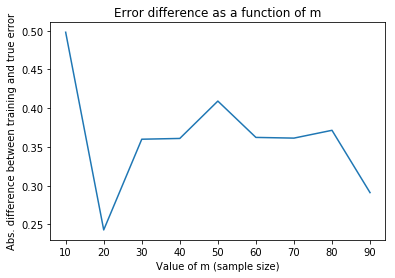

[0.4979999999999999,
 0.24299999999999994,
 0.36000000000000015,
 0.361,
 0.40920000000000023,
 0.3623333333333334,
 0.36142857142857154,
 0.3715,
 0.29111111111111115]

In [13]:
generate_data_varied_m(k)

#### 2. Note that $X_{15}$ through $X_{20}$ are completely irrelevant to predicting the value of Y . For a range of m values, repeatedly generate data sets of that size and fit trees to that data, and estimate the average number of irrelevant variables that are included in the fit tree. How much data would you need, typically, to avoid fitting on this noise?

In [25]:
def irrelevant_vars(k):
    m = list(range(10, 100, 10))
    irrelevant_count = []
    irrelevant_cols = ['X15', 'X16', 'X17', 'X18', 'X19','X20']
    for i in tqdm(range(len(m))):
        count = 0
        train_data = create_dataset(k, m[i])
        dt = DecisionTree()
        tree = dt.build_tree(train_data)
        pprint.pprint(tree)
        for irrel in irrelevant_cols:
            if irrel in tree:
                count += 1
             
        irrelevant_count.append(count)
    
    print(irrelevant_count)   

In [26]:
irrelevant_vars(k)

 11%|█         | 1/9 [00:00<00:02,  3.12it/s]

{'X5': {0: 0, 1: {'X0': {0: 1, 1: {'X6': {0: 0, 1: 1}}}}}}


 22%|██▏       | 2/9 [00:00<00:02,  3.06it/s]

{'X1': {0: 0, 1: {'X14': {0: {'X6': {0: 0, 1: 1}}, 1: 1}}}}


 33%|███▎      | 3/9 [00:01<00:02,  2.36it/s]

{'X4': {0: {'X9': {0: 0, 1: {'X0': {0: {'X2': {0: 0, 1: 1}}, 1: 1}}}},
        1: {'X5': {0: {'X0': {0: 0, 1: 1}}, 1: 1}}}}


 44%|████▍     | 4/9 [00:02<00:02,  1.73it/s]

{'X2': {0: {'X7': {0: 0, 1: {'X0': {0: 1, 1: {'X12': {0: 0, 1: 1}}}}}},
        1: {'X12': {0: {'X0': {0: {'X1': {0: 0, 1: 1}},
                               1: {'X11': {0: 0, 1: {'X9': {0: 0, 1: 1}}}}}},
                    1: 1}}}}


 56%|█████▌    | 5/9 [00:03<00:03,  1.26it/s]

{'X10': {0: {'X12': {0: {'X2': {0: 0, 1: {'X0': {0: 1, 1: 0}}}},
                     1: {'X9': {0: {'X3': {0: {'X5': {0: 1, 1: 0}}, 1: 1}},
                                1: 0}}}},
         1: {'X8': {0: {'X16': {0: 0, 1: {'X15': {0: 1, 1: 0}}}},
                    1: {'X6': {0: {'X0': {0: 0, 1: 1}}, 1: 1}}}}}}


 67%|██████▋   | 6/9 [00:04<00:02,  1.05it/s]

{'X4': {0: {'X0': {0: 0,
                   1: {'X12': {0: {'X10': {0: 0, 1: {'X14': {0: 0, 1: 1}}}},
                               1: {'X10': {0: {'X1': {0: 0, 1: 1}}, 1: 1}}}}}},
        1: {'X3': {0: {'X9': {0: 0, 1: {'X5': {0: 0, 1: 1}}}},
                   1: {'X11': {0: {'X0': {0: 1, 1: 0}}, 1: 1}}}}}}


 78%|███████▊  | 7/9 [00:06<00:02,  1.14s/it]

{'X5': {0: {'X0': {0: {'X1': {0: 0, 1: {'X3': {0: 0, 1: 1}}}},
                   1: {'X11': {0: {'X9': {0: 0, 1: 1}}, 1: 1}}}},
        1: {'X13': {0: {'X14': {0: {'X0': {0: {'X3': {0: 0,
                                                      1: {'X12': {0: 1,
                                                                  1: 0}}}},
                                           1: {'X8': {0: 0,
                                                      1: {'X1': {0: 0,
                                                                 1: 1}}}}}},
                                1: 1}},
                    1: 1}}}}


 89%|████████▉ | 8/9 [00:08<00:01,  1.32s/it]

{'X10': {0: {'X8': {0: {'X11': {0: {'X20': {0: 0,
                                            1: {'X12': {0: 0,
                                                        1: {'X0': {0: 1,
                                                                   1: 0}}}}}},
                                1: {'X1': {0: 0, 1: 1}}}},
                    1: {'X19': {0: 1,
                                1: {'X3': {0: 0, 1: {'X0': {0: 1, 1: 0}}}}}}}},
         1: {'X0': {0: {'X7': {0: {'X3': {0: 0, 1: 1}},
                               1: {'X2': {0: {'X4': {0: 0, 1: 1}}, 1: 1}}}},
                    1: 1}}}}


100%|██████████| 9/9 [00:10<00:00,  1.48s/it]

{'X10': {0: {'X4': {0: {'X9': {0: 0, 1: {'X0': {0: 1, 1: 0}}}},
                    1: {'X0': {0: {'X2': {0: {'X19': {0: 0, 1: 1}}, 1: 1}},
                               1: {'X2': {0: 1, 1: 0}}}}}},
         1: {'X12': {0: {'X13': {0: {'X8': {0: 0, 1: {'X0': {0: 1, 1: 0}}}},
                                 1: {'X9': {0: 0, 1: 1}}}},
                     1: {'X4': {0: {'X0': {0: {'X2': {0: 0, 1: 1}}, 1: 1}},
                                1: 1}}}}}}
[0, 0, 0, 0, 0, 0, 0, 0, 0]


#### 3. Generate a data set of size m = 10000, and set aside 8000 points for training, and 2000 points for testing. The remaining questions should all be applied to this data set.

In [27]:
m = 10000
train_data = create_dataset(k, m)